## Importing Libraries

In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np

from PIL import Image, ImageFile

import torch
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torch import nn
from torch.optim import lr_scheduler

import torchvision
from torchvision import transforms
import torchvision.models as models

from sklearn.model_selection import train_test_split

## Data Loading and train test split

In [2]:
data = pd.read_csv(r'C:Users\plm\Downloads\aptos2019-blindness-detection\train.csv')

In [3]:
train_csv, test_csv = train_test_split(data, test_size=0.2, random_state=42)

In [4]:
print('Train Size = {}'.format(len(train_csv)))
print('Public Test Size = {}'.format(len(test_csv)))

Train Size = 2929
Public Test Size = 733


In [5]:
train_csv.head()

,id_code,diagnosis
2181,996f9bba4ef0,0
570,286e9981dd9b,0
3389,eae70f527755,0
343,19244004583f,3
1801,7f0ffeb0a333,0


## Data Visualization

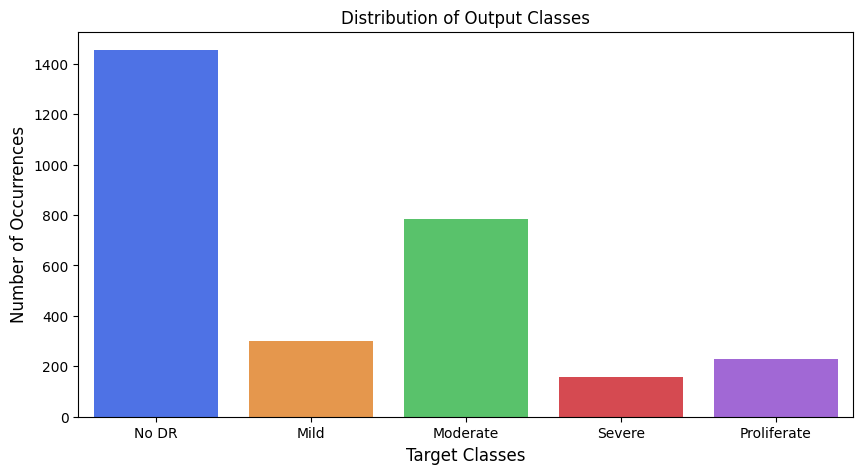

In [6]:
counts = train_csv['diagnosis'].value_counts()
class_list = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferate']
for i,x in enumerate(class_list):
    counts[x] = counts.pop(i)

plt.figure(figsize=(10,5))
sns.barplot(x=counts.index, y=counts.values, alpha=0.8, palette='bright', hue=counts.index, legend=False)
plt.title('Distribution of Output Classes')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Target Classes', fontsize=12)
plt.show()

In [7]:
base_dir = r'C:Users\plm\Downloads\aptos2019-blindness-detection'

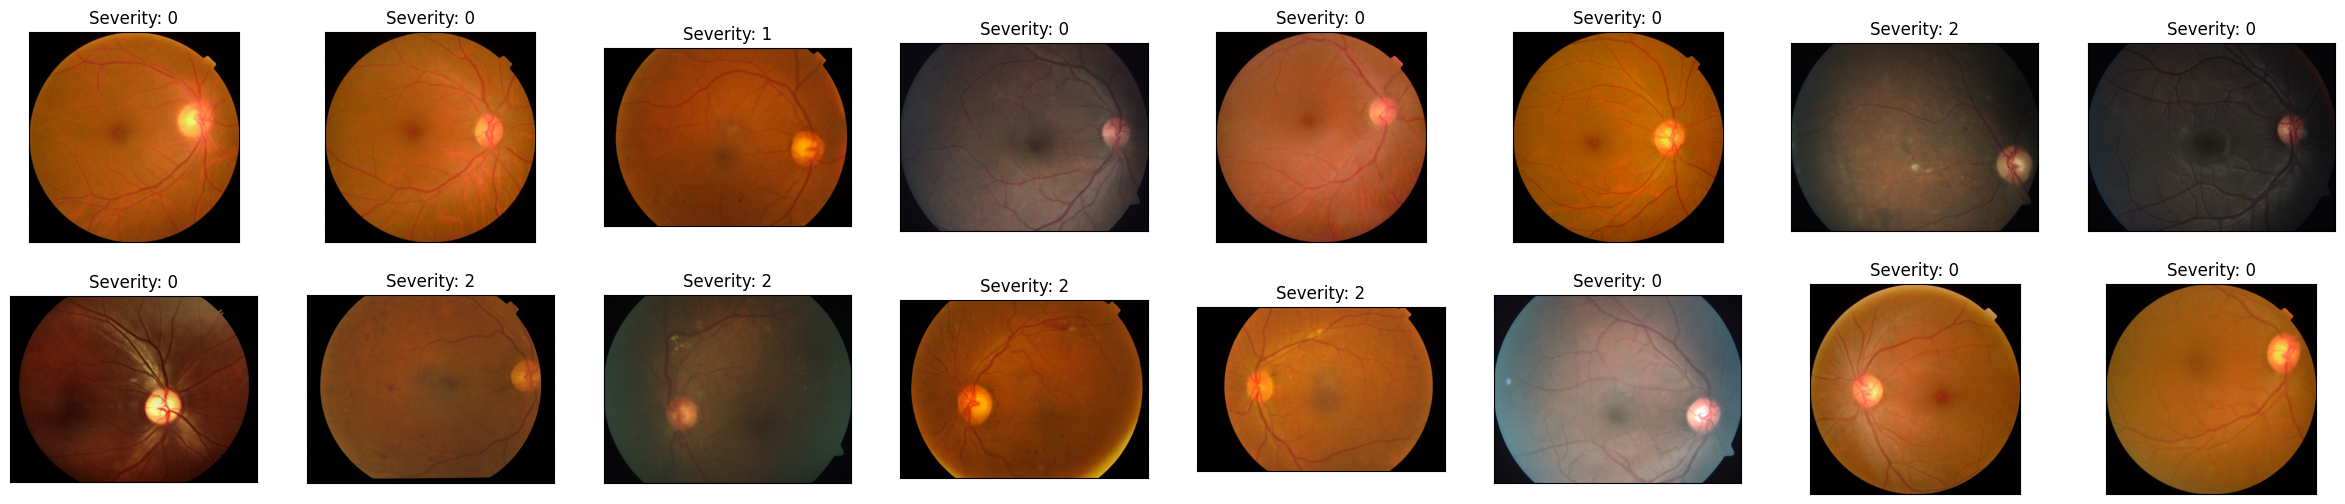

In [8]:
fig = plt.figure(figsize=(30, 6))
# display 20 images
train_imgs = os.listdir(base_dir+"/train_images")
for idx, img in enumerate(np.random.choice(train_imgs, 16)):
    ax = fig.add_subplot(2, 16//2, idx+1, xticks=[], yticks=[])
    im = Image.open(base_dir+"/train_images/" + img)
    plt.imshow(im)
    lab = data.loc[data['id_code'] == img.split('.')[0], 'diagnosis'].values[0]
    ax.set_title('Severity: %s'%lab)

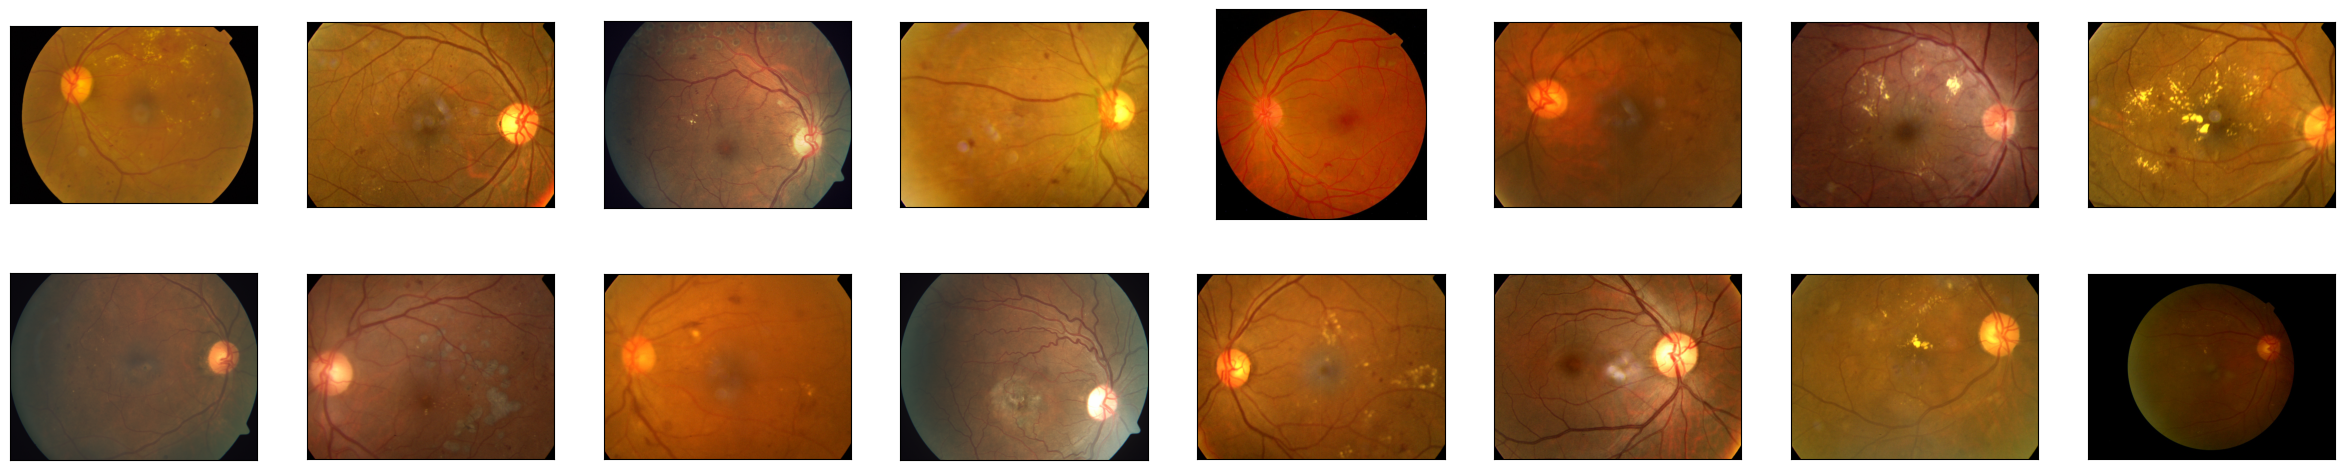

In [9]:
fig = plt.figure(figsize=(30, 6))
# display 20 images
test_imgs = os.listdir(base_dir+"/test_images")
for idx, img in enumerate(np.random.choice(test_imgs, 16)):
    ax = fig.add_subplot(2, 16//2, idx+1, xticks=[], yticks=[])
    im = Image.open(base_dir+"/test_images/" + img)
    plt.imshow(im)

## Data Loader

In [10]:
# Our own custom class for datasets
class CreateDataset(Dataset):
    def __init__(self, df_data, data_dir = '../input/', transform=None):
        super().__init__()
        self.df = df_data.values
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self): 
        return len(self.df)
    
    def __getitem__(self, index):
        img_name,label = self.df[index]
        img_path = os.path.join(self.data_dir, img_name+'.png')
        image = cv2.imread(img_path)
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [11]:
train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.4),
    #transforms.ColorJitter(brightness=2, contrast=2),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

In [12]:
train_path = r"C:\Users\plm\Downloads\aptos2019-blindness-detection\train_images"
test_path = r"C:\Users\plm\Downloads\aptos2019-blindness-detection\train_images"

In [13]:
train_data = CreateDataset(df_data=train_csv, data_dir=train_path, transform=train_transforms)
test_data = CreateDataset(df_data=test_csv, data_dir=test_path, transform=train_transforms)

In [14]:
valid_size = 0.2
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

In [15]:
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [16]:
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64,sampler=train_sampler)
validloader = torch.utils.data.DataLoader(train_data, batch_size=64, sampler=valid_sampler)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64)

In [17]:
print(f"training examples contain : {len(train_data)}")
print(f"testing examples contain : {len(test_data)}")

print(len(trainloader))
print(len(validloader))
print(len(testloader))

training examples contain : 2929
testing examples contain : 733
37
10
12


In [18]:
# LOAD ONE BATCH OF TESTING SET TO CHECK THE IMAGES AND THEIR LABELS
images, labels = next(iter(trainloader))

# Checking shape of image
print(f"Image shape : {images.shape}")
print(f"Label shape : {labels.shape}")

# denormalizing images
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

Image shape : torch.Size([64, 3, 224, 224])
Label shape : torch.Size([64])


## Normalized Images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


labels: tensor([2, 2, 0, 0, 2, 0, 0, 3, 0, 2, 0, 2, 2, 3, 2, 1, 0, 4, 2, 0, 0, 0, 2, 2,
        2, 1, 2, 0, 0, 3, 2, 0, 1, 4, 0, 0, 4, 0, 4, 3, 0, 2, 0, 0, 0, 4, 3, 0,
        0, 0, 0, 2, 2, 4, 2, 2, 2, 0, 2, 0, 0, 0, 2, 0])


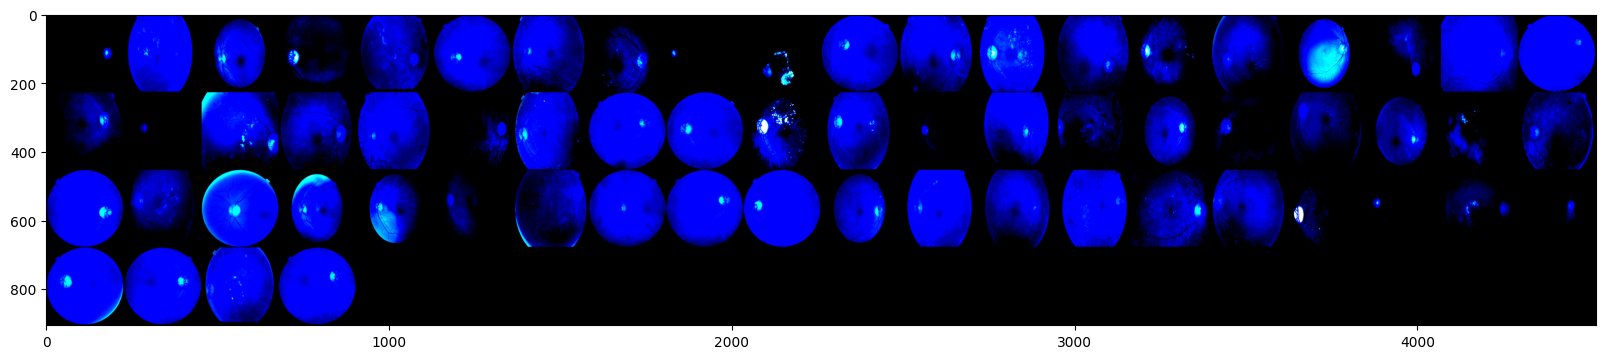

In [23]:
# plotting the images of loaded batch with given fig size and frame data    

grid = torchvision.utils.make_grid(images, nrow = 20, padding = 2)
plt.figure(figsize = (20, 20))  
plt.imshow(np.transpose(grid, (1, 2, 0)))   
print('labels:', labels)    

['No DR', 'Moderate', 'No DR', 'No DR', 'No DR', 'No DR', 'Moderate', 'Moderate', 'Moderate', 'No DR', 'Proliferative DR', 'Moderate', 'Moderate', 'Moderate', 'No DR', 'No DR', 'Moderate', 'Mild', 'Moderate', 'No DR', 'No DR', 'Moderate', 'Moderate', 'No DR', 'Proliferative DR', 'No DR', 'Moderate', 'Mild', 'No DR', 'No DR', 'Moderate', 'No DR', 'Moderate', 'Moderate', 'No DR', 'No DR', 'Proliferative DR', 'No DR', 'Moderate', 'No DR', 'Proliferative DR', 'No DR', 'Mild', 'Moderate', 'Moderate', 'No DR', 'Moderate', 'No DR', 'Proliferative DR', 'Mild', 'No DR', 'No DR', 'Moderate', 'Moderate', 'Moderate', 'No DR', 'Moderate', 'Severe', 'Moderate', 'No DR', 'No DR', 'Moderate', 'No DR', 'Moderate']


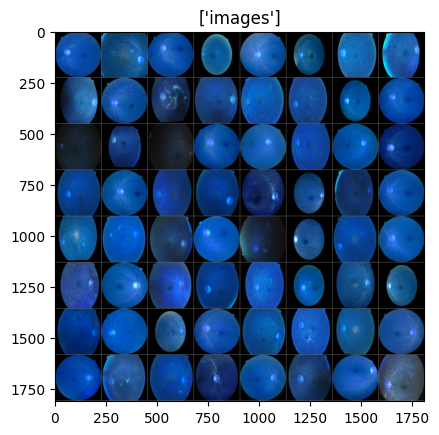

In [19]:
class_names = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative DR']

images, labels = next(iter(trainloader))
out = torchvision.utils.make_grid(images)
print(list(class_names[x] for x in labels))
imshow(out, title=["images"])

## Model Creation

In [20]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet152(weights=None) 

num_ftrs = model.fc.in_features 
out_ftrs = 5 
  
model.fc = nn.Sequential(nn.Linear(num_ftrs, 512),nn.ReLU(),nn.Linear(512,out_ftrs),nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()

model.to(device);

In [23]:
model_save_name = 'classifier_.pt'
path = f"C:\\Users\\plm\\Downloads\\aptos2019-blindness-detection\\{model_save_name}"

In [24]:
# to unfreeze more layers 
for name,child in model.named_children():
  if name in ['layer2','layer3','layer4','fc']:
    print(name + 'is unfrozen')
    for param in child.parameters():
      param.requires_grad = True
  else:
    print(name + 'is frozen')
    for param in child.parameters():
      param.requires_grad = False

conv1is frozen
bn1is frozen
reluis frozen
maxpoolis frozen
layer1is frozen
layer2is unfrozen
layer3is unfrozen
layer4is unfrozen
avgpoolis frozen
fcis unfrozen


## Other Parameters

In [25]:
optimizer = torch.optim.Adam(filter(lambda p:p.requires_grad,model.parameters()) , lr = 0.000001) 
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [26]:
def load_model(path):
  checkpoint = torch.load(path)
  model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  return model

In [27]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [28]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of trainable parameters: \n{}".format(pytorch_total_params))

Number of trainable parameters: 
58970117


## Training and testing

In [29]:
def train_and_test(e):
    epochs = e
    train_losses , test_losses, acc = [] , [], []
    valid_loss_min = np.Inf 
    model.train()
    print("Model Training started.....")
    for epoch in range(epochs):
      running_loss = 0
      batch = 0
      for images , labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        batch += 1
        if batch % 10 == 0:
            print(f" epoch {epoch + 1} batch {batch} completed") 
      test_loss = 0
      accuracy = 0
      with torch.no_grad():
        print(f"validation started for {epoch + 1}")
        model.eval() 
        for images , labels in validloader:
          images, labels = images.to(device), labels.to(device)
          logps = model(images) 
          test_loss += criterion(logps,labels) 
          ps = torch.exp(logps)
          top_p , top_class = ps.topk(1,dim=1)
          equals = top_class == labels.view(*top_class.shape)
          accuracy += torch.mean(equals.type(torch.FloatTensor))
      train_losses.append(running_loss/len(trainloader))
      test_losses.append(test_loss/len(validloader))
      acc.append(accuracy)
      scheduler.step()
      print("Epoch: {}/{}.. ".format(epoch+1, epochs),"Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),"Valid Loss: {:.3f}.. ".format(test_loss/len(validloader)),
        "Valid Accuracy: {:.3f}".format(accuracy/len(validloader)))
      model.train() 
      if test_loss/len(validloader) <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,test_loss/len(validloader))) 
        torch.save({
            'epoch': epoch,
            'model': model,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': valid_loss_min
            }, path)
        valid_loss_min = test_loss/len(validloader)    
    print('Training Completed Succesfully !')    
    return train_losses, test_losses, acc 

In [3]:
train_losses, valid_losses, acc = train_and_test(5)

Model Training started.....
 epoch 1 batch 10 completed
 epoch 1 batch 20 completed
 epoch 1 batch 30 completed
 epoch 1 batch 40 completed
validation started for 1
Epoch: 1/5..  Training Loss: 0.138..  Valid Loss: 0.115..  Valid Accuracy: 0.958
Validation loss decreased (inf --> 0.114695).  Saving model ...
 epoch 2 batch 10 completed
 epoch 2 batch 20 completed
 epoch 2 batch 30 completed
 epoch 2 batch 40 completed
validation started for 2
Epoch: 2/5..  Training Loss: 0.092..  Valid Loss: 0.122..  Valid Accuracy: 0.960
 epoch 3 batch 10 completed
 epoch 3 batch 20 completed
 epoch 3 batch 30 completed
 epoch 3 batch 40 completed
validation started for 3
Epoch: 3/5..  Training Loss: 0.081..  Valid Loss: 0.113..  Valid Accuracy: 0.964
Validation loss decreased (0.114695 --> 0.113338).  Saving model ...
 epoch 4 batch 10 completed
 epoch 4 batch 20 completed
 epoch 4 batch 30 completed
 epoch 4 batch 40 completed
validation started for 4
Epoch: 4/5..  Training Loss: 0.079..  Valid Loss

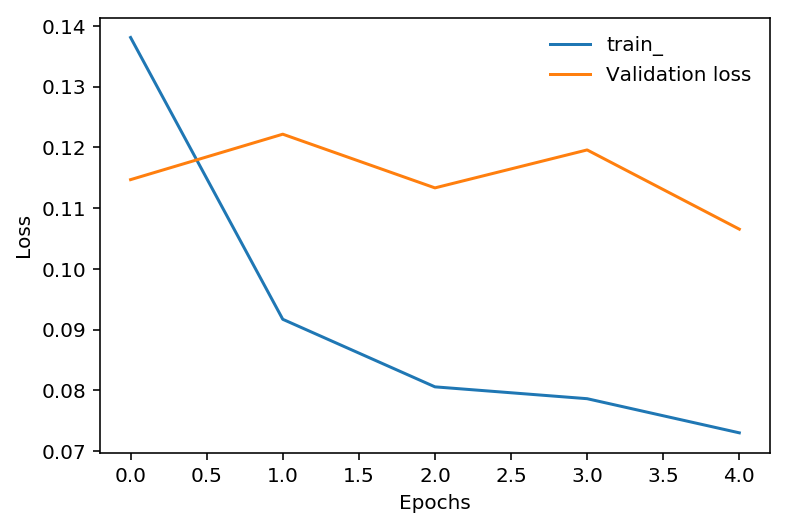

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot(train_losses, label='train_')
plt.plot(valid_losses, label='Validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(frameon=False)

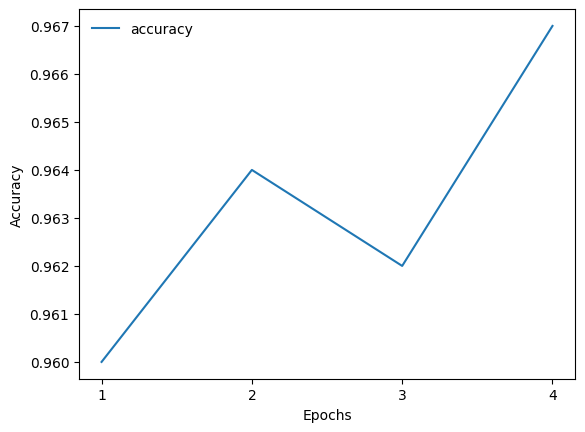

In [5]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot(acc, label='accuracy')
plt.legend("")
plt.xlabel("Epochs")
plt.ylabel('Accuracy')
plt.legend(frameon=False)

## Getting accuracy

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [21]:
model = models.resnet152(weights=None)
num_ftrs = model.fc.in_features
out_ftrs = 5
model.fc = nn.Sequential(nn.Linear(num_ftrs, 512),nn.ReLU(),nn.Linear(512,out_ftrs),nn.LogSoftmax(dim=1))
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(filter(lambda p:p.requires_grad,model.parameters()) , lr = 0.00001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
model.to(device);

In [22]:
for name,child in model.named_children():
    if name in ['layer2','layer3','layer4','fc']:
        #print(name + 'is unfrozen')
        for param in child.parameters():
            param.requires_grad = True
    else:
        #print(name + 'is frozen')
        for param in child.parameters():
            param.requires_grad = False

In [23]:
optimizer = torch.optim.Adam(filter(lambda p:p.requires_grad,model.parameters()) , lr = 0.000001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [24]:
classes = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative DR']

In [25]:
checkpoint = torch.load(f"C:\\Users\\plm\\Downloads\\aptos2019-blindness-detection\\classifier.pt",map_location='cpu')

In [26]:
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [27]:
# Function to calculate accuracy
def calculate_accuracy(resnet_model ,loader):
    resnet_model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = resnet_model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return (100 * correct / total)

In [28]:
calculate_accuracy(model, trainloader)

97.99488054607508

In [41]:
calculate_accuracy(model, testloader)

96.01672583615279
